In [1]:
# ============================================================
# Adapter: run M-GW on SpatialMETA Y7 ST & SM .h5ad files
# ============================================================
import anndata as ad
import numpy as np, torch, scipy.sparse as sp
from mgw import plotting, models, geometry
from mgw import pullback_metric_field, knn_graph
import importlib; importlib.reload(geometry)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print("Device:", device)

# ----------------------------
# Config
# ----------------------------
st_path = "/scratch/gpfs/ph3641/mgw/adata_ST_Y7_T_raw.h5ad"
sm_path = "/scratch/gpfs/ph3641/mgw/adata_SM_Y7_T_raw.h5ad"

# Which layer to use for features; set to None to use .X
ST_LAYER = None
SM_LAYER = None

# Preprocessing
log1p_features = True
zscore_per_feature = True
n_features_st = 256   # set None to keep all
n_features_sm = 256   # set None to keep all

# Graph / geodesic params
knn_k = 12
geodesic_eps = 1e-6  # used inside pullback metric calc


Device: cuda


In [2]:
import scanpy as sc
import numpy as np
import scipy.sparse as sp

A = sc.read_h5ad("/scratch/gpfs/ph3641/mgw/adata_joint_R114_T_raw.h5ad")

# --- Build boolean masks on vars ---
type_col = None
for cand in ["type", "modality", "feature_type"]:
    if cand in A.var.columns:
        type_col = cand
        break

if type_col is not None:
    t = A.var[type_col].astype(str).str.lower().fillna("")
    is_gene = t.str.contains("gene|rna|st")
    is_met  = t.str.contains("met|sm|metab")
else:
    v = A.var_names.astype(str)
    is_met  = v.str.contains(r"^\d+(\.\d+)?$|^mz[_\-]|^m/z", case=False, regex=True)
    is_gene = ~is_met

# Convert to numpy bool arrays 
is_gene = np.asarray(is_gene, dtype=bool)
is_met  = np.asarray(is_met,  dtype=bool)

# Safety checks
assert is_gene.shape[0] == A.n_vars and is_met.shape[0] == A.n_vars
assert (is_gene & is_met).sum() == 0, "Masks overlap; refine rules."
assert is_gene.sum() > 0 and is_met.sum() > 0, "One mask is empty."

adata_st = A[:, is_gene].copy()
adata_sm = A[:, is_met].copy()


In [3]:
from mgw import util
importlib.reload(util)

results = util.project_informative_features(st_path, sm_path, PCA_comp=30, CCA_comp=3,
                                           adata_X = adata_st, adata_Z = adata_sm)


Loaded:
  A (X) spots × feats: (2201, 36601)
  B (Z) spots × feats: (2201, 1299)


/home/ph3641/ManifoldAlignment/mgw/util.py:180: UserWarning: Ignoring svd_solver='auto' and using randomized, sklearn.decomposition._truncated_svd.TruncatedSVD only supports dict_keys(['arpack', 'randomized']).
  sc.tl.pca(


PCA shapes -> X: (2201, 30) Z: (2201, 30)
Feeler GW sizes: X-side 2201, Z-side 2201
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈1.9481e-03
Computing CCA Components
CCA dims: 3  (applied to full sets)


In [4]:

# --- Project features
pca=False

xs, xs2 = results["xs"], results["xt"]
if pca:
    ys, ys2 = results["X_pca"], results["Z_pca"]
else:
    ys, ys2 = results["X_cca_full"], results["Z_cca_full"]

xs_t  = torch.from_numpy(xs).to(device)
xs2_t = torch.from_numpy(xs2).to(device)
ys_t  = torch.from_numpy(ys).to(device)
ys2_t = torch.from_numpy(ys2).to(device)

dim_e   = 2
dim_f_M = ys_t.shape[1]
dim_f_N = ys2_t.shape[1]
print("dims:", dim_e, dim_f_M, dim_f_N)

# --- Train neural maps
phi = models.PhiModel(dim_e, dim_f_M, widths=(128,256,256,128)).to(device)
psi = models.PhiModel(dim_e, dim_f_N, widths=(128,256,256,128)).to(device)

phi = models.train_phi(phi, xs_t, ys_t, lr=1e-3, niter=10000, print_every=500, device=device)
psi = models.train_phi(psi, xs2_t, ys2_t, lr=1e-3, niter=10000, print_every=500, device=device)
phi.eval(); psi.eval()


dims: 2 3 3
[train_phi] step=500 loss=0.255343
[train_phi] step=1000 loss=0.167943
[train_phi] step=1500 loss=0.142761
[train_phi] step=2000 loss=0.194631
[train_phi] step=2500 loss=0.122791
[train_phi] step=3000 loss=0.123426
[train_phi] step=3500 loss=0.123662
[train_phi] step=4000 loss=0.128998
[train_phi] step=4500 loss=0.106247
[train_phi] step=5000 loss=0.105231
[train_phi] step=5500 loss=0.098993
[train_phi] step=6000 loss=0.097627
[train_phi] step=6500 loss=0.096070
[train_phi] step=7000 loss=0.090896
[train_phi] step=7500 loss=0.095945
[train_phi] step=8000 loss=0.086387
[train_phi] step=8500 loss=0.084652
[train_phi] step=9000 loss=0.083162
[train_phi] step=9500 loss=0.087396
[train_phi] step=10000 loss=0.080493
[train_phi] step=500 loss=0.861750
[train_phi] step=1000 loss=0.770004
[train_phi] step=1500 loss=0.736675
[train_phi] step=2000 loss=0.696539
[train_phi] step=2500 loss=0.685458
[train_phi] step=3000 loss=0.664265
[train_phi] step=3500 loss=0.648196
[train_phi] step=

PhiModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Softplus(beta=1.0, threshold=20.0)
    (8): Linear(in_features=128, out_features=3, bias=True)
  )
)

# Pretty underfitted, but easy to improve..

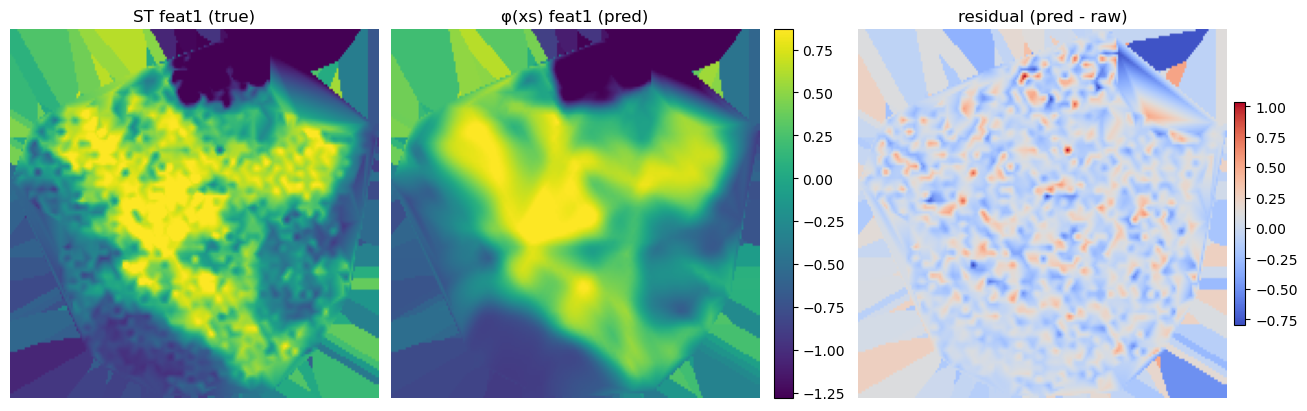

φ feat 1 {'mse': np.float64(0.046679358199146474), 'r2': np.float64(0.9153587114321036), 'corr': np.float64(0.9567529200413725)}


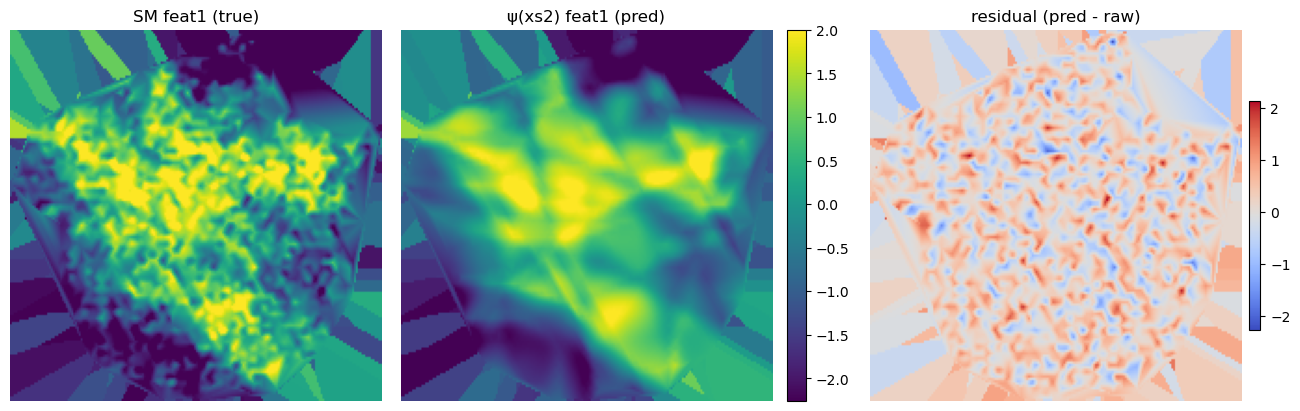

ψ feat 1 {'mse': np.float64(0.4448216575549927), 'r2': np.float64(0.7889603973172082), 'corr': np.float64(0.8929682976793017)}


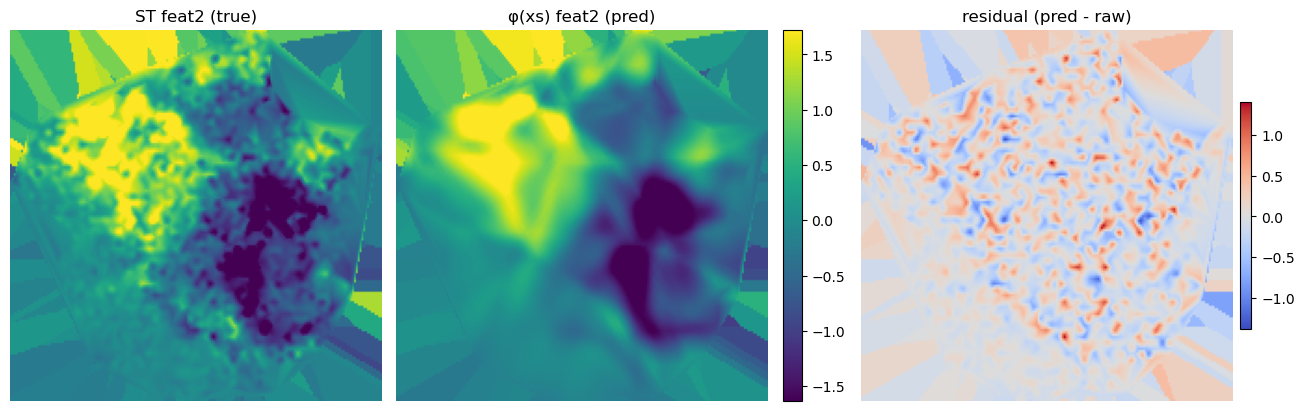

φ feat 2 {'mse': np.float64(0.14374192803364313), 'r2': np.float64(0.860277844001522), 'corr': np.float64(0.9275320151644793)}


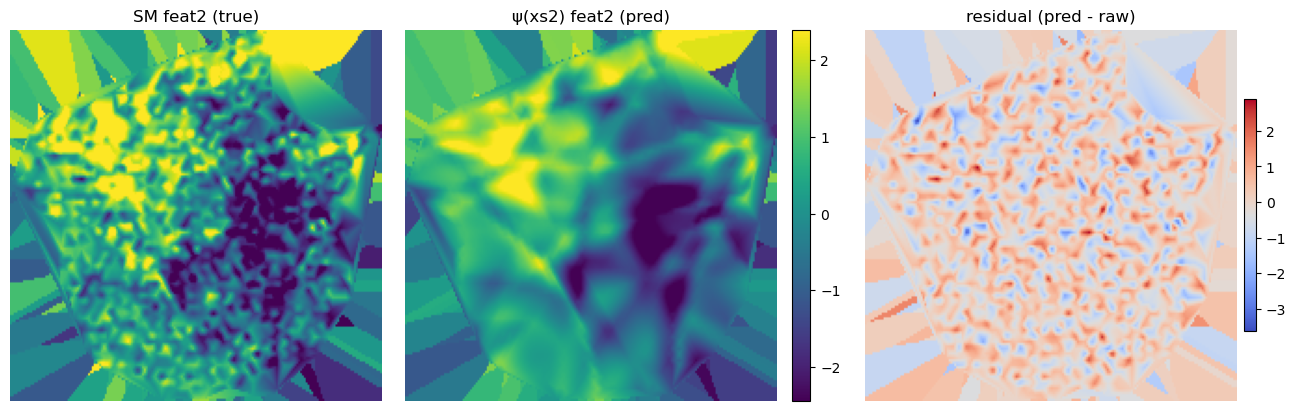

ψ feat 2 {'mse': np.float64(0.965538561457488), 'r2': np.float64(0.643701002442736), 'corr': np.float64(0.8026035186902063)}


In [6]:

# quick sanity plots/metrics on a couple random channels
import numpy as np
from mgw.plotting import fit_metrics
rng = np.random.default_rng(0)
for k in rng.choice(dim_f_M, size=min(2, dim_f_M), replace=False):
    X_pred = plotting.predict_on_model(phi, xs)
    plotting.plot_fit_on_cloud(xs, ys_t[:,k].cpu().numpy(), X_pred[:,k],
                               title_true=f'ST feat{k} (true)', title_pred=f'φ(xs) feat{k} (pred)')
    print('φ feat', k, fit_metrics(ys_t[:,k].cpu().numpy(), X_pred[:,k]))
    
    Z_pred = plotting.predict_on_model(psi, xs2)
    plotting.plot_fit_on_cloud(xs2,ys2_t[:,k].cpu().numpy(), Z_pred[:,k],
                               title_true=f'SM feat{k} (true)', title_pred=f'ψ(xs2) feat{k} (pred)')
    print('ψ feat', k, fit_metrics(ys2_t[:,k].cpu().numpy(), Z_pred[:,k]))



In [7]:
from mgw.gw import solve_gw_ott

# ---------------------------------------
# Pull-back metric tensor fields g^M, g^N
# ---------------------------------------
G_M = pullback_metric_field(phi, torch.from_numpy(xs).to(device), eps=geodesic_eps).cpu()   # (n,2,2)
G_N = pullback_metric_field(psi, torch.from_numpy(xs2).to(device), eps=geodesic_eps).cpu()   # (m,2,2)
print('Computed pull-back Jacobian fields')

# ----------------------------
# kNN graphs + geodesics
# ----------------------------
G_s = knn_graph(xs,  k=knn_k)
G_t = knn_graph(xs2,  k=knn_k)
print('Built kNN graphs')

D_M = geometry.geodesic_distances_fast(xs,  G_M, G_s)  # (n,n)
D_N = geometry.geodesic_distances_fast(xs2,  G_N, G_t)  # (m,m)
print('Geodesics computed')

def normalize_geodesics(D):
    D = np.maximum(D, 0.0)
    np.fill_diagonal(D, 0.0)
    q = np.quantile(D[np.triu_indices_from(D, k=1)], 0.99)
    return D / (q + 1e-12)

D_Mn = normalize_geodesics(D_M)
D_Nn = normalize_geodesics(D_N)
C_M  = D_Mn**2
C_N  = D_Nn**2

# ----------------------------
# Solve GW on squared geodesic costs
# ----------------------------

gw_params = dict(verbose=True, inner_maxit=2000, outer_maxit=2000,
                 inner_tol=1e-8, outer_tol=1e-8, epsilon=1e-3)

P = solve_gw_ott(C_M, C_N, **gw_params)
print("Coupling:", P.shape, "sum:", P.sum())


Computed pull-back Jacobian fields
Built kNN graphs
Geodesics computed
[OTT] GW  ε=1.00e-03  iters=-1  loss≈1.0702e-02
Coupling: (2201, 2201) sum: 1.0000006


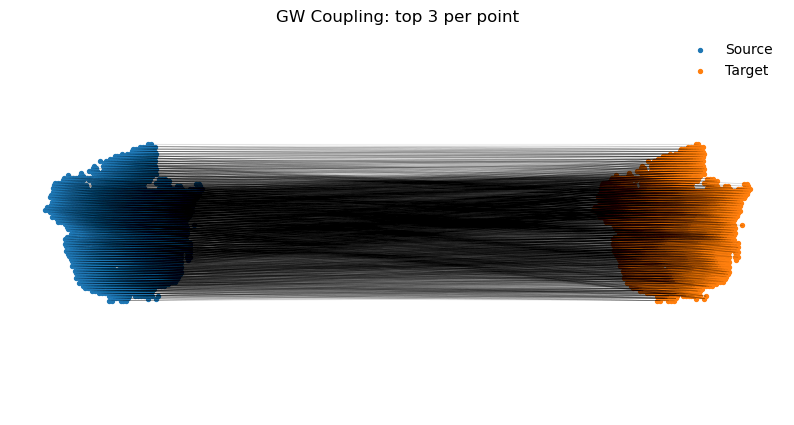

In [8]:

plotting.plot_alignment_lines_dense(xs, xs2, P, alpha=0.05)
